In [14]:
import sys
sys.path.append('../')

import numpy as np

from ForwardModeling.ForwardProcessing1D import forward_with_trace_calcing
from Inversion.Strategies.SeismDiffInversion1D import inverse
from Inversion.Optimizators.Optimizations import LBFGSBOptimization, DifferentialEvolution, TrustKrylov, TrustConstr, \
    ConjugateGradient
from Tests.test_ForwardProcessing1D import get_model_2layered, get_model_3layered
from Data.geol_models import get_model_3layered_fluid_rp_dicts
from Objects.Data.WavePlaceholder import OWT, WaveDataPlaceholder
from Objects.Models.Models import SeismicModel1D
from Objects.Attributes.RockPhysics.RockPhysicsAttribute import RockPhysicsAttribute
from Objects.Attributes.Seismic.SeismicAttribute import SeismicAttribute
from Objects.Models.Layer1D import Layer1D, LayerOPT
import time

from matplotlib import pyplot as plt
from Inversion.Strategies.SeismDiffInversion1D import func_to_optimize


In [15]:
def plot_1D_err(forward_params, nvals, min_max=None, dot=False, vline_x=None):
    
    if min_max is None:
        min_val = forward_params['model'].get_optimization_option("min", vectorize=True)
        max_val = forward_params['model'].get_optimization_option("max", vectorize=True)
        
    else:
        min_val = np.array([min_max[0]])
        max_val = np.array([min_max[1]])
    
    dval = (max_val - min_val) / nvals

    val_x = [min_val + dval*i for i in range(nvals+1)]
    errs = []
    for val in val_x:
        errs.append(func_to_optimize(val, placeholders, forward_params, helper=None, show_tol=False))
        
    plt.plot(val_x, errs)
    if dot:
        plt.plot(val_x, errs, 'o')
        
    if vline_x is not None:
        plt.vlines(vline_x, ymin=min(errs), ymax=max(errs), colors='r')
        
    plt.show()

def optimization_func_2D(forward_params, x, y):
    indexes_1 = np.arange(x.shape[0])
    indexes_2 = np.arange(x.shape[1])
    
    Z = np.zeros((x.shape[0], x.shape[1]))
    
    for ind1 in indexes_1:
        for ind2 in indexes_2:
            Z[ind1, ind2] = func_to_optimize([x[ind1, ind2], y[ind1, ind2]], placeholders, forward_params, helper=None, show_tol=False)
        
    return Z

def plot_2D_err(forward_params, nvals, ncontous=10, points=None):
    min_val = forward_params['model'].get_optimization_option("min", vectorize=True)
    max_val = forward_params['model'].get_optimization_option("max", vectorize=True)
    
    dval = (max_val - min_val) / nvals

    val_1_x = [min_val[0] + dval[0]*i for i in range(nvals[0]+1)]
    val_2_x = [min_val[1] + dval[1]*i for i in range(nvals[1]+1)]

    X, Y = np.meshgrid(val_1_x, val_2_x)

    Z = optimization_func_2D(forward_params, X, Y)
    
    plt.contourf(X, Y, Z, ncontous, cmap='seismic')
    plt.colorbar()
    
    if points is not None:
        plt.plot(points[0], points[1], marker='x', color='r')

# Четырехслойная модель с газоосадками

In [16]:
h = [
    67.5,
    22.5,
    20
]

In [17]:
# vp метан = 1548
# плотность метана 0.656 кг/м3
rho = 0.656
vp = 1548
K = rho * (vp*vp )

In [18]:
K

1571975.424

In [19]:
layer_1_seism = {
    'vp': 1500,
    'vs': 700,
    'rho': 1000
}

layer_2_rp = {
    "name": "unconsolidated",
    "components": {
                    "Ksi": {
                      "value": 38,
                      "optimize": False,
                      "min": 35,
                      "max": 40
                    },
					"Gsi": {
                      "value": 44,
                      "optimize": False,
                      "min": 40,
                      "max": 50
                    },
					"rhosi": {
                      "value": 2.2,
                      "optimize": False,
                      "min": 2,
                      "max": 2.5
                    },
                    "Ksh": {
                      "value": 21.5,
                      "optimize": False,
                      "min": 20,
                      "max": 25
                    },
					"Gsh": {
                      "value": 7,
                      "optimize": False,
                      "min": 5,
                      "max": 10
                    },
					"rhosh": {
                      "value": 2.43,
                      "optimize": False,
                      "min": 2,
                      "max": 2.5
                    },
                    "Kincl": {
                      "value": 36.9,
                      "optimize": False,
                      "min": 35,
                      "max": 40
                    },
                    "Gincl": {
                      "value": 31,
                      "optimize": False,
                      "min": 30,
                      "max": 35
                    },
                    "rhoincl": {
                      "value": 2.2,
                      "optimize": False,
                      "min": 2,
                      "max": 2.5
                    },
                    "Kfl": {
                      "value": 2.29,
                      "optimize": False,
                      "min": 0.5,
                      "max": 5
                    },
                    "rhofl": {
                      "value": 1,
                      "optimize": False,
                      "min": 0.5,
                      "max": 1.5
                    },
                    "Vsi": {
                      "value": 0.01,
                      "optimize": False,
                      "min": 0.5,
                      "max": 0.99
                    },
                    "Vsh": {
                      "value": 0.25,
                      "optimize": False,
                      "min": 0.5,
                      "max": 0.99
                    },
                    "Vincl": {
                      "value": 0,
                      "optimize": False,
                      "min": 0.5,
                      "max": 0.99
                    },
                    "phi": {
                      "value": 0.74,
                      "optimize": True,
                      "min": 0.5,
                      "max": 0.99
                    }
                  }
}

layer_3_seism = {
    'vp': 2000,
    'vs': 1000,
    'rho': 2070
}

# посмотреть в дипломе Машки!
layer_4_seism = {
    'vp': 6600,
    'vs': 3600,
    'rho': 2600,
}

In [20]:
layer_1 = Layer1D(h[0],
                  rp_attribute=None,
                  seism_attribute=SeismicAttribute(**layer_1_seism),
                  opt=LayerOPT.NO)
layer_2 = Layer1D(h[1],
                  rp_attribute=RockPhysicsAttribute(layer_2_rp['components'], layer_2_rp['name']),
                  seism_attribute=None,
                  opt=LayerOPT.RP)
layer_3 = Layer1D(h[2],
                  rp_attribute=None,
                  seism_attribute=SeismicAttribute(**layer_3_seism),
                  opt=LayerOPT.NO)
layer_4 = Layer1D(-1,
                  rp_attribute=None,
                  seism_attribute=SeismicAttribute(**layer_4_seism),
                  opt=LayerOPT.NO)

In [21]:
model = SeismicModel1D([layer_1, layer_2, layer_3, layer_4])

In [22]:
# Многоканальная коса

In [23]:
dx = 2
nx = 100
x_rec = [i * dx for i in range(1, nx+1)]
wave_types = [OWT.PdPu]

Calculating rockphysics model...
Rockphysics model calculated!
Calculating PdPu-rays...
Calculating PdPu-reflections...
Calculating p-refractions...


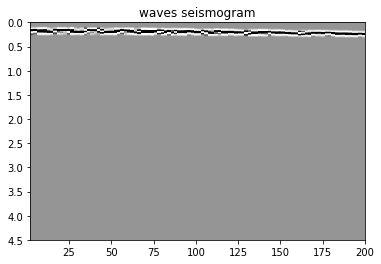

In [24]:
observe, test_seismic = \
    forward_with_trace_calcing(model, x_rec,
                               dt=3e-03, trace_len=1500, wavetypes=wave_types, display_stat=True,
        visualize_res=False, visualize_seismograms=True)

In [25]:
model.layers[0].seism_attribute.vals_dict

{'vp': 1500, 'vs': 700, 'rho': 1000}

In [26]:
model.layers[1].seism_attribute.vals_dict

{'vp': 1516.5760550243613, 'vs': 188.92894499769696, 'rho': 1369.5}

In [10]:
a = np.array([1,2,2,3])

In [12]:
a[a==2] = 4

In [13]:
a

array([1, 4, 4, 3])